In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy as sp
import seaborn as sns
from PIL import Image

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [0]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [0]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

# Setting Up the Data

In [5]:
from google.colab import files
upload = files.upload()

Saving 01_heights_weights_genders.csv to 01_heights_weights_genders.csv


In [0]:
dfhw = pd.read_csv("01_heights_weights_genders.csv")

In [7]:
dfhw.shape

(10000, 3)

In [8]:
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [9]:
df = dfhw.sample(500, replace = False)
np.sum(df.Gender == "Male")

248

In [10]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False, False,  True, False,  True, False,  True,  True,  True,
       False])

# Logistic Regression

using mask
BEST {'C': 0.001} 0.92 {'mean_fit_time': array([0.00194674, 0.00085416, 0.00095463, 0.00091419, 0.00085974,
       0.00089211, 0.00092807, 0.00092897]), 'std_fit_time': array([2.20017711e-03, 4.53749080e-05, 2.95250391e-05, 3.83231743e-05,
       1.76719479e-05, 5.19904281e-05, 7.71821887e-05, 7.48598803e-05]), 'mean_score_time': array([0.00024428, 0.00025401, 0.00030832, 0.00024571, 0.00024633,
       0.00024767, 0.00024729, 0.00024118]), 'std_score_time': array([2.63081047e-05, 1.63796167e-05, 4.14876827e-05, 1.23007352e-05,
       2.41763493e-05, 1.39424119e-05, 1.08037032e-05, 2.99915031e-06]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.95081967, 0.95081967, 0.95081967, 0.950819

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

(<matplotlib.axes._subplots.AxesSubplot at 0x7f10c16b0748>,
 array([[56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        ...,
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496]]),
 array([[ 83.49307747,  83.49307747,  83.49307747, ...,  83.49307747,
          83.49307747,  83.49307747],
        [ 85.2392416 ,  85.2392416 ,  85.2392416 , ...,  85.2392416 ,
          85.2392416 ,  85.2392416 ],
        [ 86.98540573,  86.98540573,  86.98540573, ...,  86.98540573,
          86.98540573,  86.

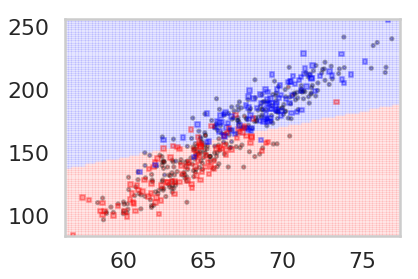

In [11]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog)

In [12]:
clflog.predict(Xtest)

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0])

In [13]:
clflog.predict_proba(Xtest)

array([[0.30418055, 0.69581945],
       [0.28981318, 0.71018682],
       [0.61309847, 0.38690153],
       [0.69074225, 0.30925775],
       [0.91956753, 0.08043247],
       [0.31570895, 0.68429105],
       [0.90556964, 0.09443036],
       [0.64660315, 0.35339685],
       [0.33212051, 0.66787949],
       [0.91714996, 0.08285004],
       [0.20594497, 0.79405503],
       [0.10559306, 0.89440694],
       [0.06382461, 0.93617539],
       [0.38927748, 0.61072252],
       [0.83752969, 0.16247031],
       [0.86056985, 0.13943015],
       [0.08398422, 0.91601578],
       [0.35446497, 0.64553503],
       [0.03626852, 0.96373148],
       [0.35480824, 0.64519176],
       [0.60073628, 0.39926372],
       [0.79581447, 0.20418553],
       [0.05239647, 0.94760353],
       [0.0515948 , 0.9484052 ],
       [0.11425991, 0.88574009],
       [0.03803333, 0.96196667],
       [0.02715421, 0.97284579],
       [0.36420392, 0.63579608],
       [0.90759117, 0.09240883],
       [0.70563331, 0.29436669],
       [0.

In [14]:
clflog.predict_proba(Xtest)[:, 1]

array([0.69581945, 0.71018682, 0.38690153, 0.30925775, 0.08043247,
       0.68429105, 0.09443036, 0.35339685, 0.66787949, 0.08285004,
       0.79405503, 0.89440694, 0.93617539, 0.61072252, 0.16247031,
       0.13943015, 0.91601578, 0.64553503, 0.96373148, 0.64519176,
       0.39926372, 0.20418553, 0.94760353, 0.9484052 , 0.88574009,
       0.96196667, 0.97284579, 0.63579608, 0.09240883, 0.29436669,
       0.72400776, 0.80474608, 0.59958472, 0.33318802, 0.30864666,
       0.3072568 , 0.56597966, 0.72506599, 0.21658465, 0.64912616,
       0.34142532, 0.7772609 , 0.94714556, 0.89539468, 0.95563736,
       0.0257149 , 0.14001712, 0.7371205 , 0.93564966, 0.61109791,
       0.4883199 , 0.80045092, 0.54812561, 0.95532921, 0.94177911,
       0.8319957 , 0.04707375, 0.11659998, 0.50217502, 0.98323064,
       0.09070325, 0.79224749, 0.25031228, 0.08186215, 0.27713151,
       0.04043431, 0.51454468, 0.42971657, 0.97373649, 0.6472773 ,
       0.46713181, 0.72350654, 0.87853759, 0.54059057, 0.50134

(array([35., 13., 13., 16., 10., 15., 21., 20., 24., 33.]),
 array([ 1.15620123, 11.00867177, 20.86114232, 30.71361286, 40.5660834 ,
        50.41855395, 60.27102449, 70.12349504, 79.97596558, 89.82843612,
        99.68090667]),
 <a list of 10 Patch objects>)

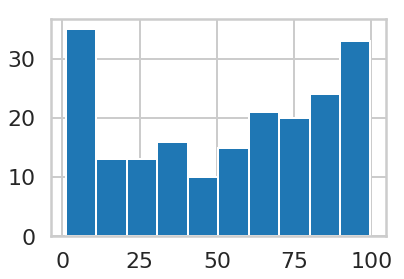

In [15]:
plt.hist(clflog.predict_proba(Xtest)[:, 1]*100)

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


TypeError: ignored

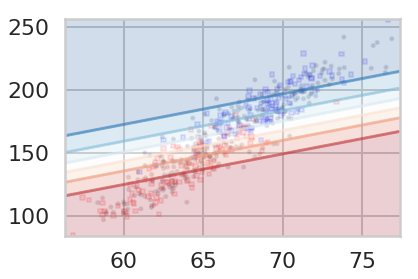

In [17]:
plt.figure()
ax = plt.gca()

points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh = False, alpha = 0.001)
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog)

In [18]:
clflog.score(Xtest, ytest)

0.89

# SVM

using mask
BEST {'C': 0.01} 0.9233333333333333 {'mean_fit_time': array([0.00130782, 0.00075397, 0.00158281, 0.00399103, 0.03691401,
       0.25938711, 0.4111968 ]), 'std_fit_time': array([3.00724929e-04, 6.96627266e-05, 5.84698209e-04, 1.09188029e-03,
       1.79400433e-02, 1.41931443e-01, 1.75851589e-01]), 'mean_score_time': array([0.00060787, 0.00029626, 0.00030708, 0.00032969, 0.00028777,
       0.00045314, 0.00050998]), 'std_score_time': array([2.26882036e-04, 1.37644974e-05, 2.11766168e-05, 4.22711232e-05,
       2.00067143e-05, 2.08103230e-05, 5.58884883e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.95081967, 0.95081967, 0.95081967, 0.95081967, 0.95081967,
       0.95081967, 0.95081967]), 'split1_test_score': a

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f10b1a669e8>,
 array([[56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        ...,
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496],
        [56.28543437, 56.49837801, 56.71132165, ..., 76.94096767,
         77.15391132, 77.36685496]]),
 array([[ 83.49307747,  83.49307747,  83.49307747, ...,  83.49307747,
          83.49307747,  83.49307747],
        [ 85.2392416 ,  85.2392416 ,  85.2392416 , ...,  85.2392416 ,
          85.2392416 ,  85.2392416 ],
        [ 86.98540573,  86.98540573,  86.98540573, ...,  86.98540573,
          86.98540573,  86.

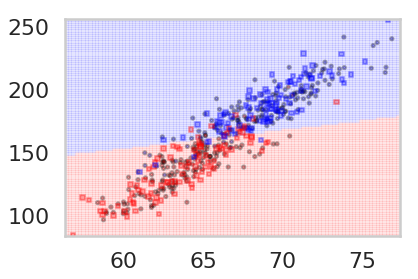

In [19]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm)

In [20]:
clfsvm.decision_function(Xtest)

array([ 1.40850928,  1.52546529, -1.0980999 , -1.27058862, -3.69220502,
        1.17404359, -3.35071306, -0.69321648,  0.80251161, -3.28423937,
        1.90528742,  2.96444746,  3.56141936,  0.60589054, -2.28635322,
       -2.98748493,  3.44251735,  0.69225845,  4.93911758,  0.94522698,
       -0.60965264, -2.05275481,  3.98440465,  3.99926077,  2.78596343,
        4.49435409,  4.93885117,  0.88037162, -3.52532093, -1.31754693,
        1.30543573,  1.9546758 ,  0.55619187, -1.14728456, -1.30721988,
       -1.07627733,  0.39317821,  1.83839895, -1.48185468,  0.92883476,
       -0.94302795,  1.81112238,  4.02308323,  3.37292731,  4.45059486,
       -5.38878466, -2.45730417,  0.99821936,  3.73514164,  0.56631217,
       -0.30329973,  1.73257074,  0.14833296,  4.26118025,  4.1042217 ,
        2.13298946, -4.21261502, -3.11364305, -0.19231586,  5.7902548 ,
       -3.86290206,  1.8944538 , -2.01793761, -3.73386136, -1.75468746,
       -4.87984124, -0.18116778, -0.28093789,  4.77414178,  0.41

(array([ 6., 17., 23., 28., 37., 42., 25., 19.,  2.,  1.]),
 array([-6.67413551, -5.1868606 , -3.69958568, -2.21231077, -0.72503586,
         0.76223905,  2.24951396,  3.73678887,  5.22406378,  6.71133869,
         8.1986136 ]),
 <a list of 10 Patch objects>)

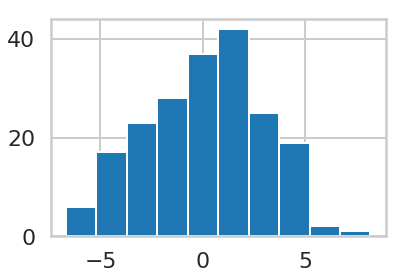

In [21]:
plt.hist(clfsvm.decision_function(Xtest))

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


TypeError: ignored

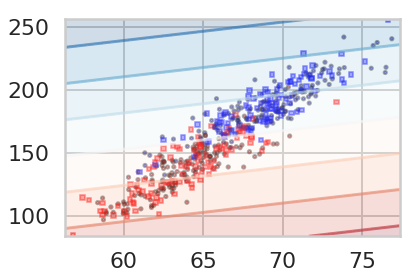

In [22]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False)
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False)

In [0]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: ignored

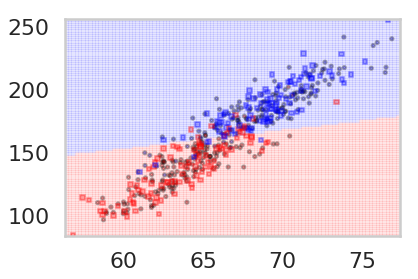

In [25]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

# Confusion Matrix

In [26]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[81, 18],
       [ 4, 97]])

In [27]:
from sklearn.metrics import classification_report
print(classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        99
           1       0.84      0.96      0.90       101

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.89      0.89       200



The Cancer Doctor

In [0]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [29]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 30,  69],
       [  0, 101]])

# ROC Curve

In [0]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

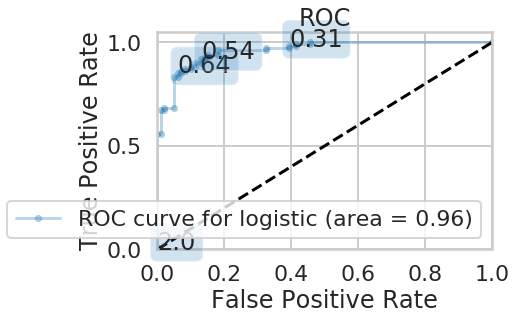

In [31]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

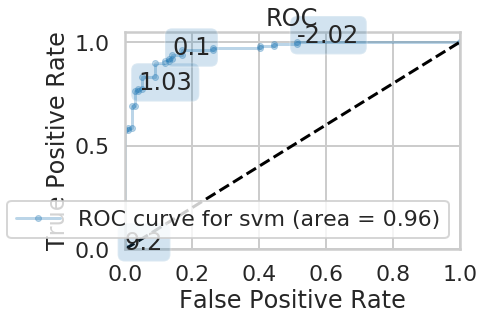

In [32]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)